Riya & Austin<br/>Section 3

# Question

### What would happen if Olin students kept coming to class during a meningococcal meningitis outbreak?

# Model

&nbsp; &nbsp; &nbsp; Initially, when choosing our model, we looked at a variety of different diseases, before remembering an interesting discovery relating to the vaccination policy at Olin. Students are not required to receive the meningococcal meningitis if they sign a waiver acknowledging the risks of the disease. As a result, a case (albeit an unlikely one) could arise where an entire student body could choose to opt out of this vaccine, and leave themselves susceptible to an outbreak. While this assumption is valid in that it is possible, with a student body like the students at Olin, it isn’t very likely. </br>

&nbsp; &nbsp; &nbsp; In regard to Olin, we standardized the population to three hundred and sixty students, and assumed that the average Olin student is in contact with 25 students per day on average. We chose these based on our own estimations of class size, and personal experiences with students interacting with others on a daily basis. Additionally, as from our limited experience with the students around us, we assumed that Olin students would continue to come to class if they felt a bit under the weather, as people tend to feel in the incubation period of meningococcal meningitis. </br>

&nbsp; &nbsp; &nbsp; One of the biggest assumptions we had to make was in regard to the contagion rate of the disease. After much research, we discovered that there doesn’t seem to sufficient information on the rates of infection or contagion in relation to meningococcal meningitis, so we looked for other avenues of validating our rates. We instead assumed it would be accurate to base our transmission rate on that of a similarly spread disease, influenza. We multiplied the average rate of contagion of influenza  by a proportion of the lifetime of meningococcal meningitis bacteria to that of the influenza bacteria, to adjust for the actual rate of transmission.</br>

## Setting up the environment

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import matplotlib.pyplot as plt


# import functions from the modsim.py module
from modsim import *

## Setting up the initial state

**S:** Susceptible </br>

**C:** Infected students coming to class </br>

**Q:** Quarantine </br>

**R:** Recovered </br>

**D:** Dead </br>

In [18]:
init = State(S=360, C=1, Q=0, R=0, D=0)


,values
S,360
C,1
Q,0
R,0
D,0


## Setting up the System
**i:** Contagion rate </br>
* (rate of contagion of the flu * (meningococcal virus lifetime) / (influenza virus lifetime) * average contact rate of an Olin student
* Sources:
    * Survial of Meningococcal Virus outside a host (5 hours): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2870569/
    * Survival of Influenza Virus outside a host (24 hours): https://www.nhs.uk/common-health-questions/infections/how-long-do-bacteria-and-viruses-live-outside-the-body/
    * Contagion rate of the influenza: https://www.globalsecurity.org/security/ops/hsc-scen-3_flu-transmission.htm
 

**g:** The "go to the hospital" rate, or rate of the infected that were quarantined </br>
* Also known as the time when students start showing symptoms (end of the incubation period)
* Incubation period of Meningococcal Meningitis (2 to 10 days): https://www.healthline.com/health/how-contagious-meningitis

**alpha:** Recovery rate from the quarantine </br>

**beta:** Death rate from the quarantine </br>
* Sources for quarantine rates: https://www.health24.com/Mental-Health/Brain/Neurological-conditions/Meningitis-20120721

    

In [20]:
system = System(
    i=0.1 * 5/24 * 25,
    g=0.25,
    alpha=0.4,
    beta=0.1,
)

None

## Update Function


In [4]:
def update_func(state, system, dt=1):
    unpack(state)
    unpack(system)
    
    # Prevent division by zero
    if S <= 0:
        delta = 0
    else:
        delta = i/S
    
    # Prevent the susceptible population from going under zero
    infections = min([S * C * delta, S])
    
    # Differential Equations
    dSdt = -infections * dt
    dCdt = (infections - C*g) * dt
    dQdt = (C*g - Q*alpha - Q*beta) * dt
    dRdt = (Q*alpha) * dt
    dDdt = (Q*beta) * dt
    
    # Ensure that there are no issues with scope or order of updates
    s,c,q,r,d = S,C,Q,R,D
    
    return State(
        S = s + dSdt,
        C = c + dCdt,
        Q = q + dQdt,
        R = r + dRdt,
        D = d + dDdt
    )

## Run Simulation

In [5]:
def run_simulation(system, init, t_end, dt):
    unpack(system)
    
    # Create a timeframe for results, and add the initial state 
    results = TimeFrame(columns=init.index)
    results.row[0] = init
    
    # Loop from 0 to t_end by step of dt through the results timeframe and add data from updatefunc()
    for t in linrange(0, t_end, dt):
        results.row[t+dt] = update_func(results.row[t], system, dt)
    
    return results

## Plotting

In [6]:
# Function to plot a timeframe
def plot_results(results):
    plot(results['S'], '-', label='Susceptible')
    plot(results['C'], '--', label='Coming to class')
    plot(results['Q'], ':', label='Quarantined')
    plot(results['R'], '.-', label='Recovered')
    plot(results['D'], '.--', label='Dead')
    decorate(xlabel='Time (days)', ylabel='Population', title='Overall Simulation Data')

## Sweeping Function

In [7]:
def sweep_param(system, init, t_end, dt, param, output, values, calc = lambda x: x):
    '''
    system, init, t_end, dt: variables for calling run_simulation
    param: the name of the system parameter to be swept
    output: the results column to plot against
    values: the values that the sweep should test
    calc (optional): lambda expression that applies a formula to the sweep
                     value before assigning it to the system parameter
    '''

    from copy import deepcopy
    
    sweep_results = SweepSeries()
    
    for val in values:
        # deepcopy system object for each new value to prevent accidental variable contamination
        sweep_system = deepcopy(system)
        # apply formula (if provided) to sweep value and assign it as system parameter in new system object
        sweep_system[param] = calc(val)
        # run the simulation and store the appropriate results column in the SweepSeries
        sweep_results[val] = run_simulation(sweep_system, init, t_end, dt)[output]
    
    return sweep_results

In [8]:
def plot_sweep(sweep_results, title, xlabel, ylabel):
    # generate color range to make graphs more readable
    from colour import Color
    purple = Color('purple')
    color_range = list(purple.range_to(Color('red'), len(sweep_results.index)))
    
    # iterate through each row of SweepSeries and color range together
    for (entry,color,val) in zip(sweep_results, color_range, sweep_results.index):
        plot(entry, color=color.rgb, label=str(round(val,3)))
    decorate(title=title, xlabel=xlabel, ylabel=ylabel)

# Results

**Our Question**: What would happen if Olin students kept coming to class during a meningococcal meningitis outbreak? </br>

**Our Answer**: Through research and our simulation, we discovered after running for 80 days, approximately 19.99% of Olin students would die after moving to quarantine, and 79.79% would recover. 

Saving figure to file figs/overall.png


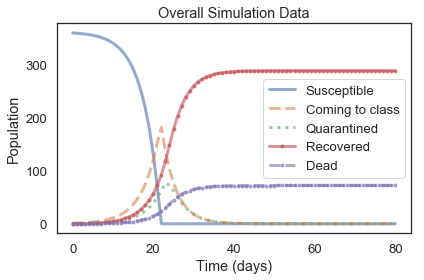

In [9]:
results = run_simulation(system, init, 80, 1)
plot_results(results)
savefig('figs/overall.png')

This graph shows the overall results of our simulation running for 50 days, and the change in our five stocks over time. As the graph shows, the susceptible population drops at a proportional rate before leveling off at day 22 when there are zero people left. On the same day, the number of infected students coming to class reaches its peak of 181 students, after which there are no more new students to infect.

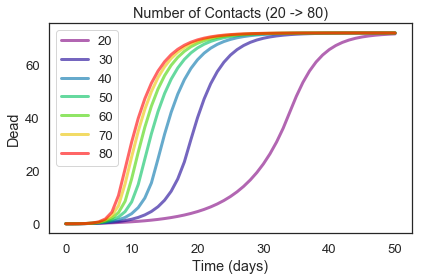

In [10]:
contact_range = linrange(20,80,10,endpoint=True)
sweep_results = sweep_param(system, init, 50, 1, 'i', 'D', contact_range, lambda x: 0.1 * 5/24 * x)
plot_sweep(sweep_results, 'Number of Contacts (20 -> 80)', 'Time (days)', 'Dead')

The above parameter sweep demonstrates the influence of student-to-student contact rate on student deaths over time. The contact rate is defined as the number of susceptible students one infected student is likely to have close contact with per day. Sweeping from 20 contacts per day to 80 contacts per day shows that, although the end result is the same, lowering the contact rate between students slows the overall death rate, which can provide time for an intervention.

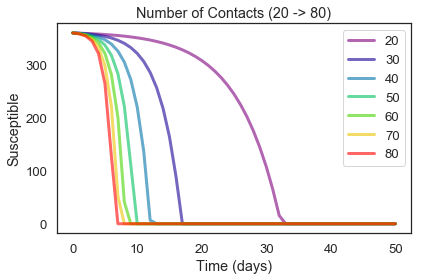

In [11]:
sweep_results = sweep_param(system, init, 50, 1, 'i', 'S', contact_range, lambda x: 0.1 * 5/24 * x)
plot_sweep(sweep_results, 'Number of Contacts (20 -> 80)', 'Time (days)', 'Susceptible')

The above parameter sweep demonstrates the influence of student-to-student contact rate on the number of susceptible students remaining over time. Sweeping from 20 contacts per day to 80 contacts per day shows a proportional drop in the rapidity of susceptible reaching zero, but once again, the varying contact rate would provide time for an intervention in this outbreak.

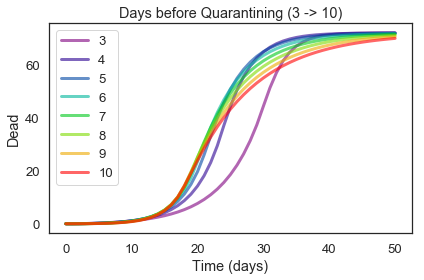

In [12]:
g_day_range = linspace(3, 10, 8, endpoint=True)
sweep_results = sweep_param(system, init, 50, 1, 'g', 'D', g_day_range, lambda x: 1/x)
plot_sweep(sweep_results, 'Days before Quarantining (3 -> 10)', 'Time (days)', 'Dead')

The above parameter sweep shows the impact of varying incubation periods of meningococcal meningitis on students deaths over time. As a student can be contagious and coming to class without showing symptoms, this is the most dangerous time for the disease. A limitation of our model is that all students would have the same incubation period with this sweep, resulting in the shortest incubation period having the largest number of students in the hospital fastest.

# Interpretation

*Note: Interpretation of the above graphs has been included in captions below each one*

## Main Limitation
&nbsp; &nbsp; &nbsp; The main way this model fails to represent reality is that it is not time-dependent. In a real outbreak, a patient might go from susceptible to infected, remain in an incubation period for 4 days, and then suddenly become quarantined. All of these transitions between stocks would be discreet and there would be a time step delay between each. Instead, due to how this model represents flows as continuous functions of rates and proportions, as soon as a stock becomes populated, portions of it are immediately transferred to the next stock within the next time step. That would be analogous to a portion of a patient becoming infected, then having one fourth of that patient becoming quarantined every day for the next four days. The end result is the same, one whole patient transfers from infected to quarantined after 4 days, but it does have some effects on the models results. Namely, rather than rising continuously from the first day, the quarantine stock would remain at zero for at least the duration of the incubation period before beginning to climb. The ending survival rate would be the same, but because of this discrepancy, this model is somewhat out-of-regime.

## Iteration
&nbsp; &nbsp; &nbsp; Our iterative process resulted in some large changes to our code throughout the creation of this model. Initially, we modeled this disease as if it were more similar to the flu, with milder symptoms and a more gradual onset period. Once infected, we expected some patients to immediately quarantine themselves and the rest to be able to come to class despite the symptoms. Some of those coming to class would also eventually flow to quarantine, modeling how symptoms might become worse over time. As we wanted to model an increased risk of death if a student were to continue coming to class instead of seeking immediate treatment, we introduced new flow rates directly from “coming to class” to dead and recovered, and therefore created two parallel tracts from susceptible to recovered or dead. All in all, not only was this model more complicated than our final, it was also less accurate. </br>

&nbsp; &nbsp; &nbsp; As we did more research, we learned that meningococcal meningitis symptoms have two discrete phases: a relatively asymptomatic incubation phase and a rapidly onset symptomatic phase. In reality, the flu-like symptoms of the incubation phase would be so mild that there’s basically no chance anyone would seek quarantine over them, whereas the second phase would be so severe that everyone in that phase would be immediately hospitalized. Using the same stocks as before, we were able to simplify our model such that C represents those in the incubation phase, Q represents those in the second phase (hospitalized), and S only flows to C, which only flows to Q, and only those in Q can flow to dead or recovered.


# Abstract

&nbsp; &nbsp; &nbsp; We were trying to determine what would happen if Olin students kept coming to class during an meningococcal meningitis outbreak. Through research and our simulation, we discovered after running for 50 days, approximately 19.99% of Olin students would die after moving to quarantine, and 79.97% would recover. 


!["Overall Graph"](figs/overall.png)

&nbsp; &nbsp; &nbsp; This graph shows the overall results of our simulation over 50 days, and the change in our five stocks over time. As the graph shows, the susceptible population drops at a proportional rate before leveling off at day 22 when there are zero people left. On the same day, the number of infected students coming to class reaches its peak of 181 students, after which there are no more new students to infect.
</br>

&nbsp; &nbsp; &nbsp; The biggest issue found with a meningococcal meningitis outbreak is that a student can be infected (and contagious) for many days or weeks before they start to show symptoms and are discovered to be sick. As a result, the spread can be incredibly deadly, unless vaccines or quarantines are enacted on the entire population quickly.